# EDA of Netflix Content Engagement

In [1]:
import pandas as pd
import numpy as np
import re

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font", family="AppleGothic") #경로 설정
import matplotlib.colors as mcolors


df = pd.read_csv('../data/total_netflix_2023 new.csv')
print(df.shape)
df.head()

(18332, 9)


,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description
0,The Night Agent: Season 1,Yes,2023-03-23,812100000,7696.0,6.0,"Biography, Drama, History","persian empire,empire,5th century b.c.,achaeme...",The film follows headstrong Ginny who meets Su...
1,Ginny & Georgia: Season 2,Yes,2023-01-05,665100000,5216.0,5.7,"Comedy, Drama,Romance","producer,three word title,headstrong,arranged ...","Betrothed against her will to King George, you..."
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000,11869.0,8.4,['Short'],"prequel,queen,historical,england,queen charlot...",A holiday romantic comedy that captures the ra...
3,Wednesday: Season 1,Yes,2022-11-23,507700000,50077.0,7.4,"['Drama', 'History', 'Romance']","christmas,coming out,holidays,lesbian relation...",The film follows headstrong Ginny who meets Su...
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,503000000,45624.0,6.6,"['Comedy', 'Romance']","telenovela,drug trafficking,cartel,femme fatal...","While fleeing from dangerous assailants, an as..."


## 1. Data Proprocessing

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18332 entries, 0 to 18331
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                18332 non-null  object
 1   Available Globally?  18332 non-null  object
 2   Release Date         18332 non-null  object
 3   Hours Viewed         18332 non-null  object
 4   Number of Ratings    18332 non-null  object
 5   Rating               18332 non-null  object
 6   Genre                18332 non-null  object
 7   Key Words            18332 non-null  object
 8   Description          18332 non-null  object
dtypes: object(9)
memory usage: 1.3+ MB


- 중복 확인

In [3]:
duplicates = df[df.duplicated()]
display(duplicates)

# 중복 제거
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print()
df.shape

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description
18242,Wolf // Varg,No,0,0,0,0,0,0,0
18268,You Are the Apple of My Eye // 那些年，我們一起追的女孩,No,0,0,0,0,0,0,0


(18330, 9)

- 데이터 클리닝 : Genre

In [4]:
df['Genre'] = df['Genre'].str.replace('[', '').str.replace(']', '').str.replace("'", "")

- Season 포함 여부에 따라 데이터 비닝

In [5]:
df['Type'] = df['Title'].str.contains('Season', case=False, na=False).map({True: 'TV Show', False: 'Movie'})

- 수치형 컬럼 클리닝 후 숫자로 변환

In [6]:
# errors='coerce'에러가 생길경우 NaN 처리
df['Hours Viewed'] = pd.to_numeric(df['Hours Viewed'].str.replace(',', ''), errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'].str.replace(',', ''), errors='coerce')

In [7]:
df['release_date_parsed'] = pd.to_datetime(df['Release Date'], errors='coerce', infer_datetime_format=True)

In [8]:
df.head()

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description,Type,release_date_parsed
0,The Night Agent: Season 1,Yes,2023-03-23,812100000.0,7696.0,6.0,"Biography, Drama, History","persian empire,empire,5th century b.c.,achaeme...",The film follows headstrong Ginny who meets Su...,TV Show,2023-03-23
1,Ginny & Georgia: Season 2,Yes,2023-01-05,665100000.0,5216.0,5.7,"Comedy, Drama,Romance","producer,three word title,headstrong,arranged ...","Betrothed against her will to King George, you...",TV Show,2023-01-05
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000.0,11869.0,8.4,Short,"prequel,queen,historical,england,queen charlot...",A holiday romantic comedy that captures the ra...,TV Show,2022-12-30
3,Wednesday: Season 1,Yes,2022-11-23,507700000.0,50077.0,7.4,"Drama, History, Romance","christmas,coming out,holidays,lesbian relation...",The film follows headstrong Ginny who meets Su...,TV Show,2022-11-23
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,503000000.0,45624.0,6.6,"Comedy, Romance","telenovela,drug trafficking,cartel,femme fatal...","While fleeing from dangerous assailants, an as...",Movie,2023-05-04


In [9]:
# 한국어 포함 여부를 판단하는 함수
def contains_korean(text):
    return 1 if re.search('[가-힣]', text) else 0

# Korea 컬럼 생성
df['Korea'] = df['Title'].apply(contains_korean)

In [10]:
df['Korea'].value_counts()

0    17192
1     1138
Name: Korea, dtype: int64

## 2. EDA

### 2.0. Type of Contents

In [11]:
# Type별로 Hoursviewed 합계를 구함
pd.options.display.float_format = '{:.0f}'.format

df_sum_type = df.groupby('Type')['Hours Viewed'].sum().reset_index()
df_sum_type

,Type,Hours Viewed
0,Movie,87253400000
1,TV Show,73470400000


In [12]:
df_korea = df[df['Korea'] == 1]
df_K_sum_type = df_korea.groupby('Type')['Hours Viewed'].sum().reset_index()
df_K_sum_type

,Type,Hours Viewed
0,Movie,5147300000
1,TV Show,4889000000


In [13]:
df_count_type = df.groupby('Type')['Hours Viewed'].count().reset_index()
df_count_type

,Type,Hours Viewed
0,Movie,12447
1,TV Show,5881


In [14]:
df_k_count_type = df_korea.groupby('Type')['Hours Viewed'].count().reset_index()
df_k_count_type

,Type,Hours Viewed
0,Movie,718
1,TV Show,420


### 2.1. Cumulative Hours Watched Yearly

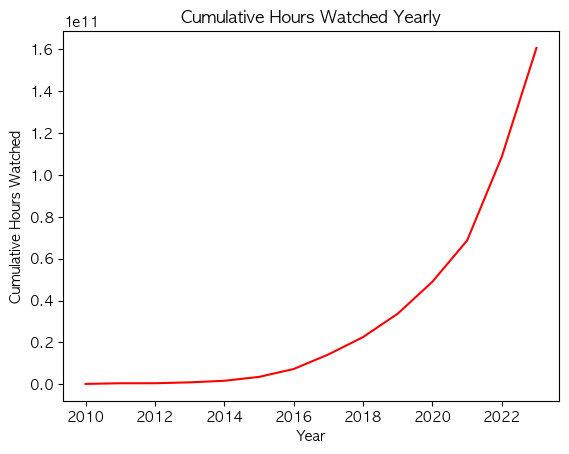

In [15]:
df_clean = df.dropna(subset=['release_date_parsed']) # Nat 제거

# year 추출
df_clean['release_year'] = df_clean['release_date_parsed'].dt.year

# Group by
yearly_hours = df_clean.groupby('release_year')['Hours Viewed'].sum()

# Calculate
cumulative_hours = yearly_hours.cumsum()

# Plotting
cumulative_hours.plot(kind='line', title='Cumulative Hours Watched Yearly', color='red')
plt.xlabel('Year')
plt.ylabel('Cumulative Hours Watched')
plt.show()

In [16]:
cumulative_hours

release_year
2010      207300000
2011      528300000
2012      538800000
2013      957300000
2014     1712100000
2015     3558300000
2016     7337100000
2017    14271000000
2018    22590000000
2019    33767100000
2020    49038600000
2021    68721300000
2022   108753900000
2023   160723800000
Name: Hours Viewed, dtype: float64

### 2.2. Group by Genre

In [17]:
df.head()

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description,Type,release_date_parsed,Korea
0,The Night Agent: Season 1,Yes,2023-03-23,812100000,7696,6,"Biography, Drama, History","persian empire,empire,5th century b.c.,achaeme...",The film follows headstrong Ginny who meets Su...,TV Show,2023-03-23,0
1,Ginny & Georgia: Season 2,Yes,2023-01-05,665100000,5216,6,"Comedy, Drama,Romance","producer,three word title,headstrong,arranged ...","Betrothed against her will to King George, you...",TV Show,2023-01-05,0
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000,11869,8,Short,"prequel,queen,historical,england,queen charlot...",A holiday romantic comedy that captures the ra...,TV Show,2022-12-30,1
3,Wednesday: Season 1,Yes,2022-11-23,507700000,50077,7,"Drama, History, Romance","christmas,coming out,holidays,lesbian relation...",The film follows headstrong Ginny who meets Su...,TV Show,2022-11-23,0
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,503000000,45624,7,"Comedy, Romance","telenovela,drug trafficking,cartel,femme fatal...","While fleeing from dangerous assailants, an as...",Movie,2023-05-04,0


In [18]:
df['Genre'] = df['Genre'].replace('0', np.nan)
df['Genre'] = df['Genre'].dropna().astype(str).str.split(',')
print(df['Genre'].head())

0    [Biography,  Drama,  History]
1        [Comedy,  Drama, Romance]
2                          [Short]
3      [Drama,  History,  Romance]
4               [Comedy,  Romance]
Name: Genre, dtype: object


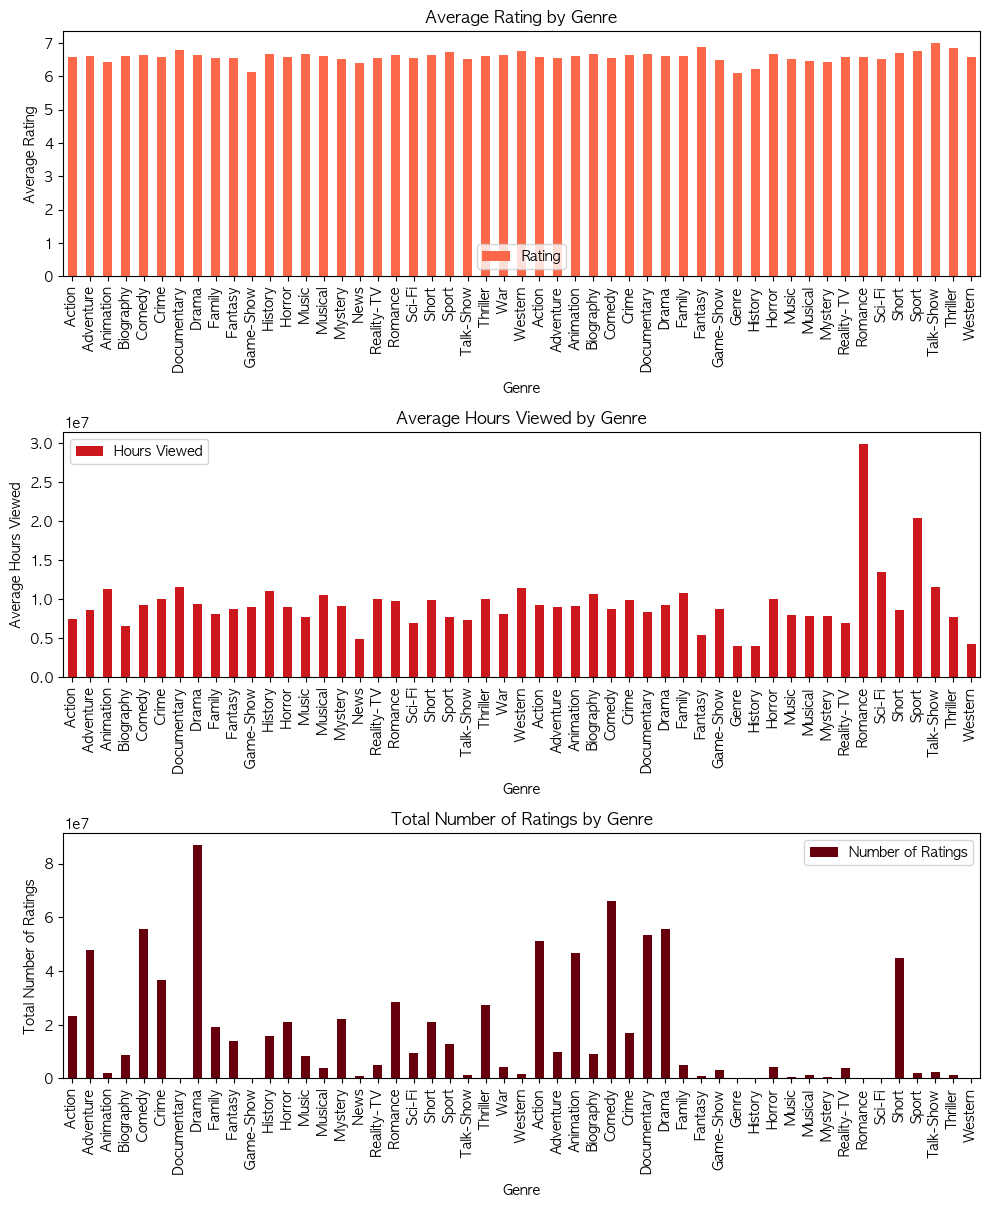

In [19]:
# Group by Genre
df_exploded = df.explode('Genre')
genre_stats = df_exploded.groupby('Genre').agg({'Rating': 'mean', 'Hours Viewed': 'mean', 'Number of Ratings': 'sum'})

# colormap 
cmap = plt.get_cmap('Reds')
bright_cmap = mcolors.LinearSegmentedColormap.from_list('bright_cmap', cmap(np.linspace(0.5, 1, 256)))

# Plotting
axes = genre_stats.plot(kind='bar', subplots=True, layout=(4, 1), figsize=(10, 15), sharex=False, cmap=bright_cmap)

# subplots
axes[0][0].set_title('Average Rating by Genre')
axes[0][0].set_xlabel('Genre')
axes[0][0].set_ylabel('Average Rating')

axes[1][0].set_title('Average Hours Viewed by Genre')
axes[1][0].set_xlabel('Genre')
axes[1][0].set_ylabel('Average Hours Viewed')

axes[2][0].set_title('Total Number of Ratings by Genre')
axes[2][0].set_xlabel('Genre')
axes[2][0].set_ylabel('Total Number of Ratings')


plt.tight_layout()

# Display the plot
plt.show()

In [20]:
def plot_genre_stats(df, colormap_ratings='Blues', colormap_hours='Greens', colormap_ratings_count='Reds'):
    # Group by Genre
    df_exploded = df.explode('Genre')
    genre_stats = df_exploded.groupby('Genre').agg({'Rating': 'mean', 'Hours Viewed': 'mean', 'Number of Ratings': 'sum'})

    # Sort by average rating
    genre_stats = genre_stats.sort_values(by='Rating', ascending=False)

    # Colormaps
    cmap_ratings = plt.get_cmap(colormap_ratings)
    bright_cmap_ratings = mcolors.LinearSegmentedColormap.from_list('bright_cmap_ratings', cmap_ratings(np.linspace(0.5, 1, 256)))

    cmap_hours = plt.get_cmap(colormap_hours)
    bright_cmap_hours = mcolors.LinearSegmentedColormap.from_list('bright_cmap_hours', cmap_hours(np.linspace(0.5, 1, 256)))

    cmap_ratings_count = plt.get_cmap(colormap_ratings_count)
    bright_cmap_ratings_count = mcolors.LinearSegmentedColormap.from_list('bright_cmap_ratings_count', cmap_ratings_count(np.linspace(0.5, 1, 256)))

    # Plotting
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=False)

    # Plotting each subplot with different colormaps
    genre_stats['Rating'].plot(kind='bar', ax=axes[0], color=bright_cmap_ratings(np.linspace(0.5, 1, len(genre_stats))), edgecolor='black')
    genre_stats['Hours Viewed'].plot(kind='bar', ax=axes[1], color=bright_cmap_hours(np.linspace(0.5, 1, len(genre_stats))), edgecolor='black')
    genre_stats['Number of Ratings'].plot(kind='bar', ax=axes[2], color=bright_cmap_ratings_count(np.linspace(0.5, 1, len(genre_stats))), edgecolor='black')

    # Setting titles and labels
    axes[0].set_title('Average Rating by Genre')
    axes[0].set_ylabel('Average Rating')

    axes[1].set_title('Average Hours Viewed by Genre')
    axes[1].set_ylabel('Average Hours Viewed')

    axes[2].set_title('Total Number of Ratings by Genre')
    axes[2].set_xlabel('Genre')
    axes[2].set_ylabel('Total Number of Ratings')

    # Tight layout
    plt.tight_layout()

    # Display the plot
    plt.show()


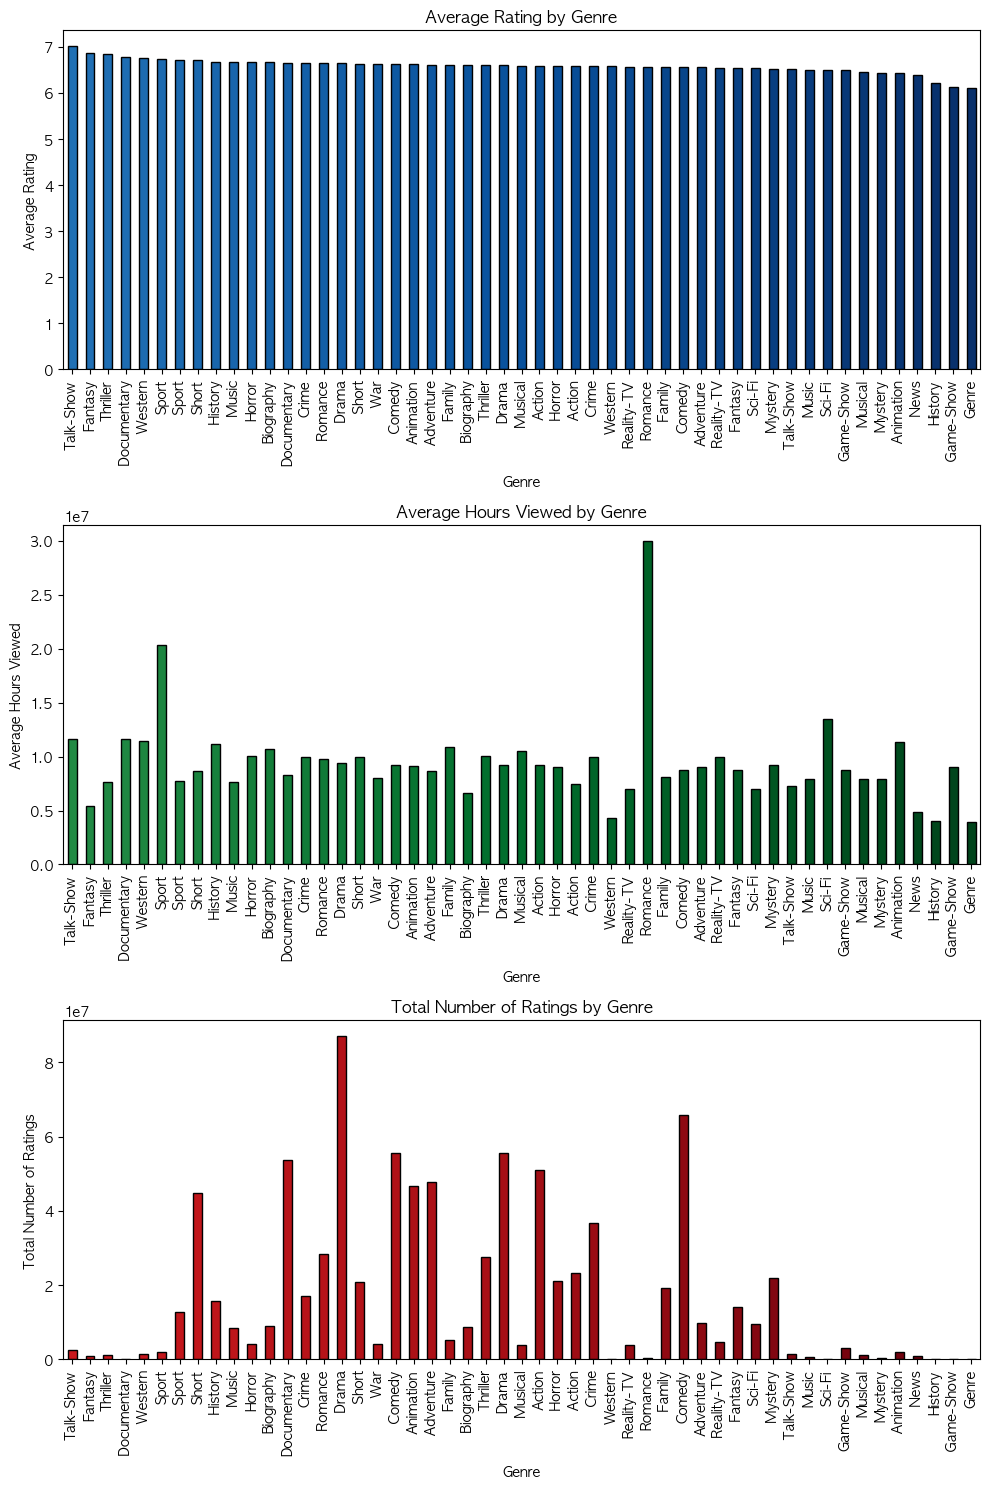

In [21]:
plot_genre_stats(df, colormap_ratings='Blues', colormap_hours='Greens', colormap_ratings_count='Reds')

#### 2.2.1. Movie

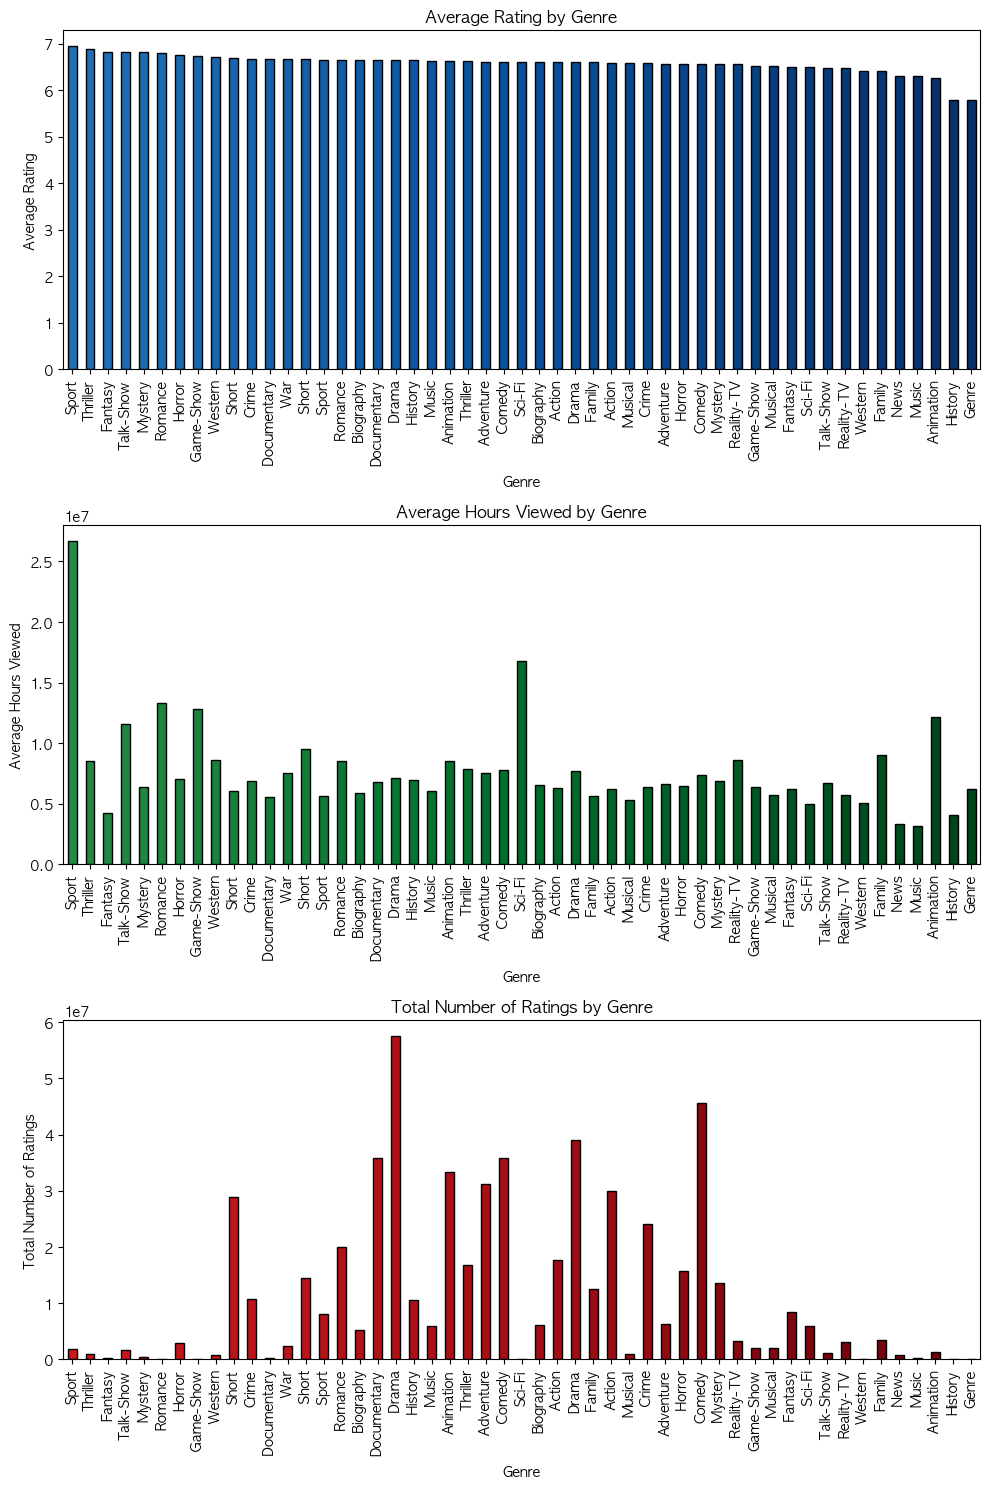

In [22]:
# 필터링
df_filtered = df[df['Type'] == 'Movie']
plot_genre_stats(df_filtered, colormap_ratings='Blues', colormap_hours='Greens', colormap_ratings_count='Reds')

#### 2.2.2. TV Show

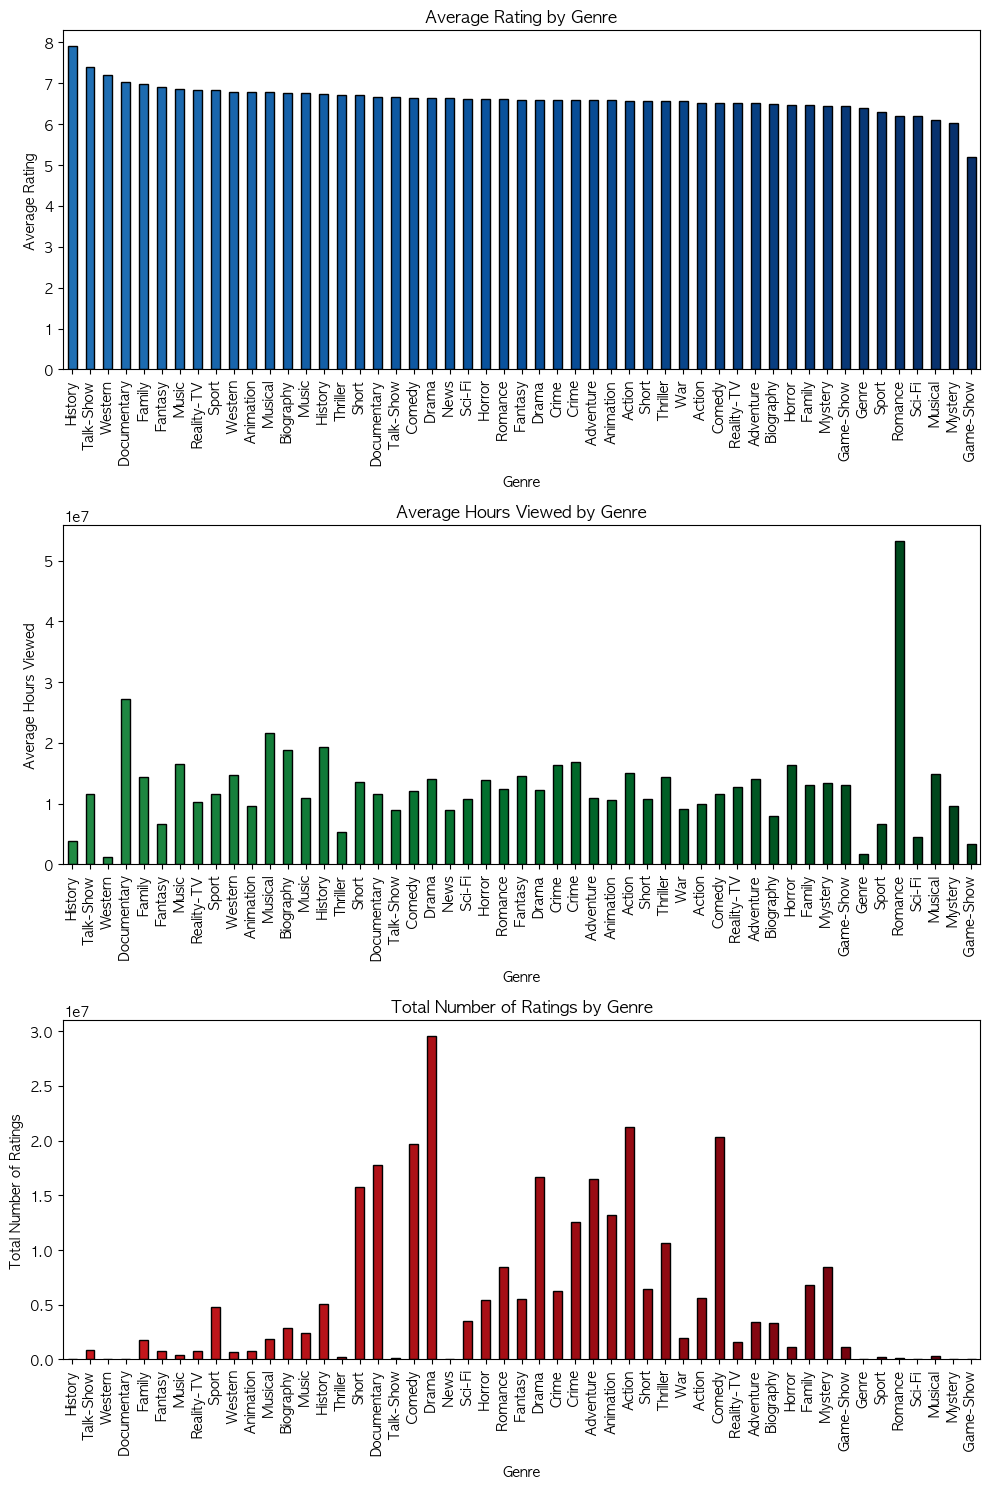

In [23]:
# 필터링
df_filtered = df[df['Type'] == 'TV Show']
plot_genre_stats(df_filtered, colormap_ratings='Blues', colormap_hours='Greens', colormap_ratings_count='Reds')

### 2.3. Correlation

In [24]:
# Convert 'Available Globally?' to a binary numeric column 
df_exploded['Available Globally?'] = df_exploded['Available Globally?'].map({'Yes': 1, 'No': 0})

# Group by 'Genre' and calculate the sum of 'hours viewed' and the mean of 'Available Globally?'
genre_popularity = df_exploded.groupby('Genre').agg({'Hours Viewed': 'sum', 'Available Globally?': 'mean'})

# Now calculate the correlation
correlation = genre_popularity.corr()

# Display the correlation matrix
display(correlation)

,Hours Viewed,Available Globally?
Hours Viewed,1,0
Available Globally?,0,1


In [25]:
def calculate_genre_correlation(df, group_column, value_column1, value_column2):
    """
    Calculate correlation between two columns within each group defined by another column.
    
    Parameters:
        df (DataFrame): DataFrame containing the data.
        group_column (str): Name of the column used to group the data.
        value_column1 (str): Name of the first column used for correlation calculation.
        value_column2 (str): Name of the second column used for correlation calculation.
    
    Returns:
        Series: Series containing correlation values for each group.
    """
    grouped = df.groupby(group_column)
    
    def calculate_correlation(group):
        return group[value_column1].corr(group[value_column2])
    
    genre_correlation = grouped.apply(calculate_correlation)
    
    return genre_correlation

# Usage example
genre_correlation = calculate_genre_correlation(df_exploded, 'Genre', 'Hours Viewed', 'Available Globally?')


In [26]:
# Group the data by 'Genre'
grouped = df_exploded.groupby('Genre')

# Define a function to calculate the correlation for each group
def calculate_correlation(group):
    return group['Hours Viewed'].corr(group['Available Globally?'])

# Apply the function to each genre group
genre_correlation = grouped.apply(calculate_correlation)

In [27]:
genre_correlation

Genre
 Action          0
 Adventure       0
 Animation       0
 Biography       0
 Comedy          0
 Crime           0
 Documentary     0
 Drama           0
 Family          0
 Fantasy         0
 Game-Show       1
 History         0
 Horror          0
 Music           0
 Musical         0
 Mystery         0
 News           -0
 Reality-TV      0
 Romance         0
 Sci-Fi          0
 Short           0
 Sport           0
 Talk-Show       0
 Thriller        0
 War             0
 Western         0
Action           0
Adventure        0
Animation        0
Biography        0
Comedy           0
Crime            0
Documentary      0
Drama            0
Family           0
Fantasy          0
Game-Show        0
Genre          NaN
History         -0
Horror           0
Music            0
Musical          0
Mystery          0
Reality-TV      -0
Romance          0
Sci-Fi           1
Short            0
Sport            0
Talk-Show        0
Thriller         0
Western         -0
dtype: float64

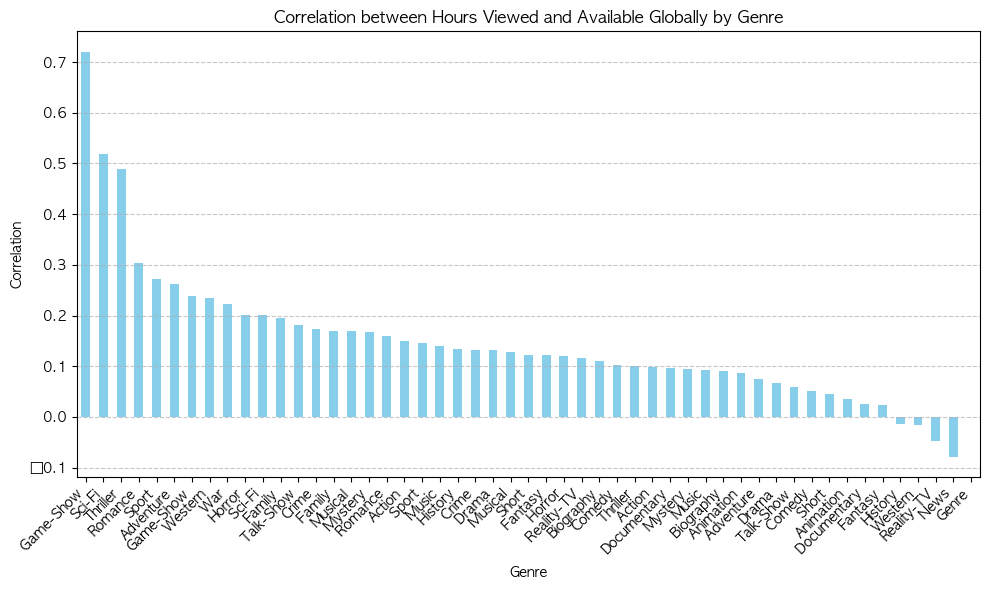

In [28]:
# 새로운 figure와 axis 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 상관 관계를 시각화
genre_correlation.sort_values(ascending=False).plot(kind='bar', color='skyblue', ax=ax)

# 그래프 타이틀과 레이블 설정
ax.set_title('Correlation between Hours Viewed and Available Globally by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Correlation')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 그래프 표시
plt.show()


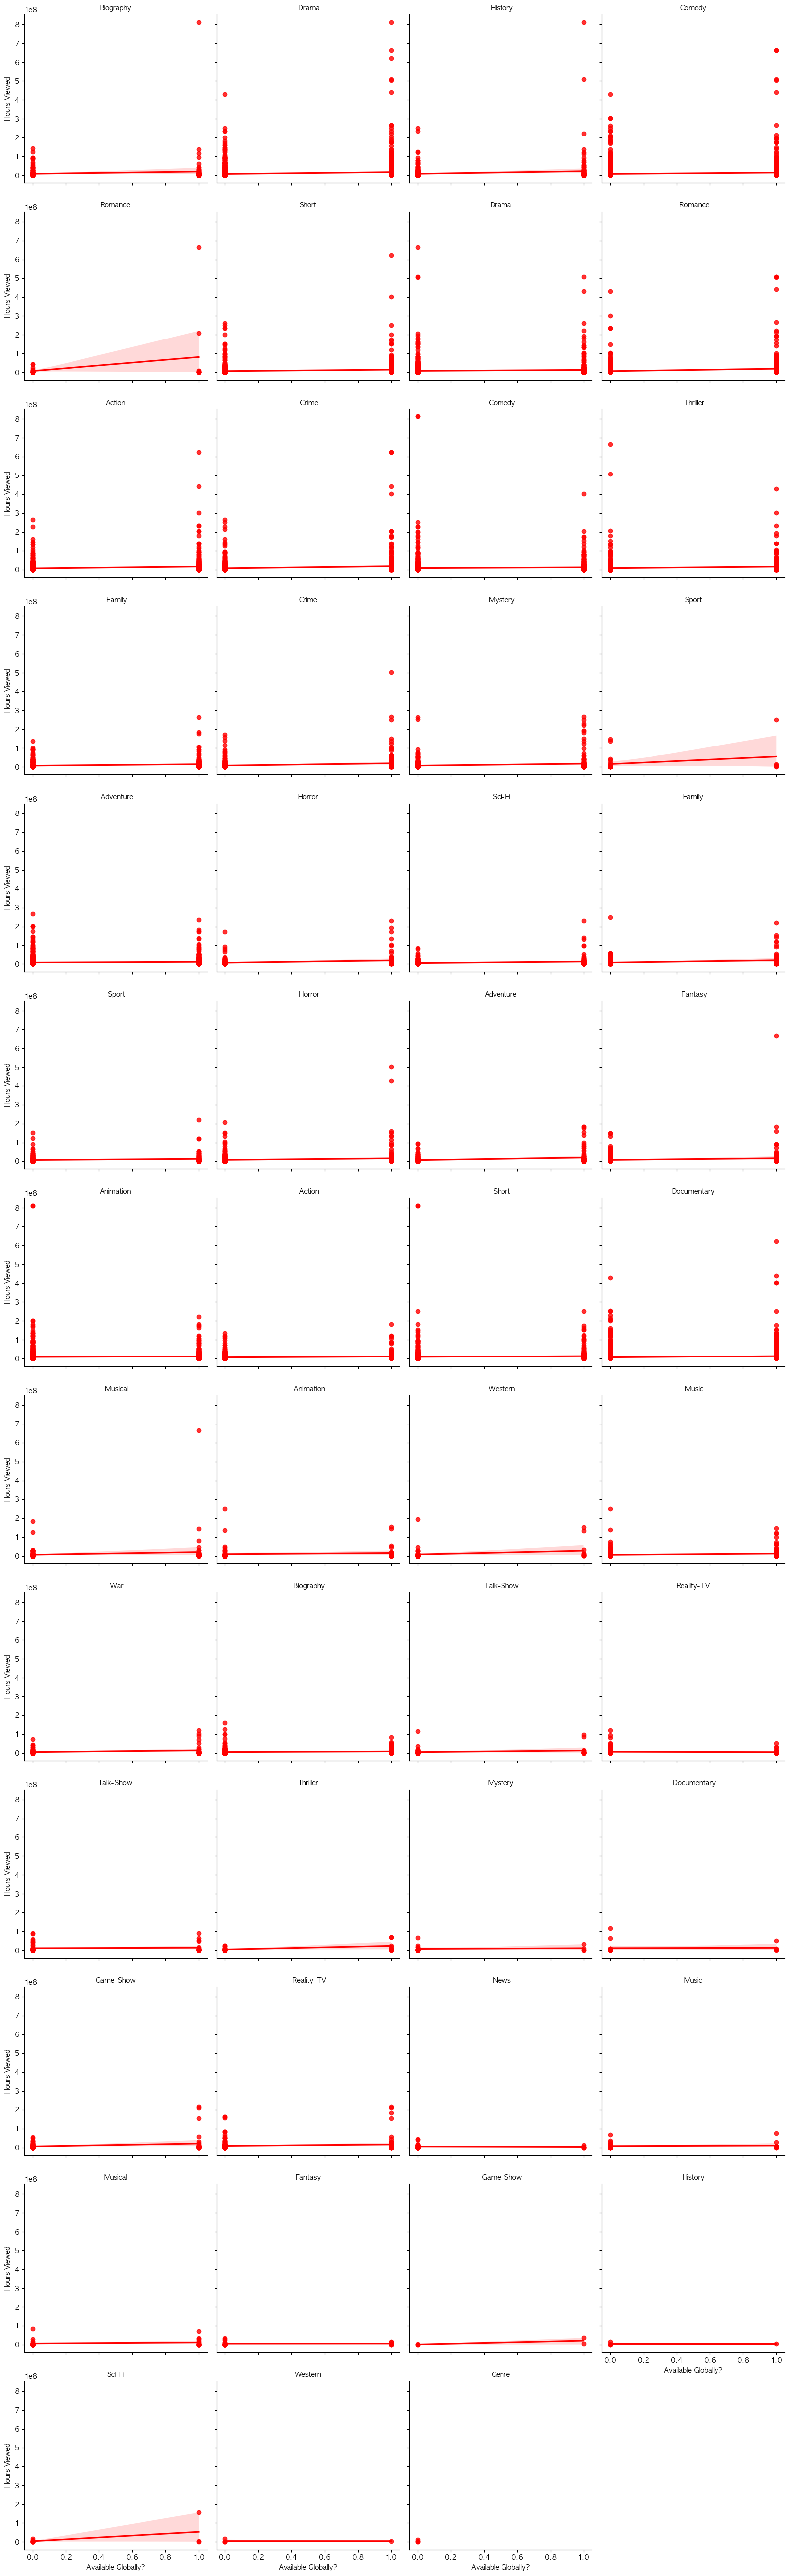

In [29]:
# Set up a FacetGrid to plot multiple genres
g = sns.FacetGrid(df_exploded, col='Genre', col_wrap=4, height=4, aspect=1)

#FacetGrid
g.map(sns.regplot, 'Available Globally?', 'Hours Viewed', color='red')

# Set up titles
g.set_titles("{col_name}")

# Show the plots
plt.tight_layout()
plt.show()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18330 entries, 0 to 18329
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Title                18330 non-null  object        
 1   Available Globally?  18330 non-null  object        
 2   Release Date         18330 non-null  object        
 3   Hours Viewed         18328 non-null  float64       
 4   Number of Ratings    18326 non-null  float64       
 5   Rating               18326 non-null  float64       
 6   Genre                17909 non-null  object        
 7   Key Words            18330 non-null  object        
 8   Description          18330 non-null  object        
 9   Type                 18330 non-null  object        
 10  release_date_parsed  14637 non-null  datetime64[ns]
 11  Korea                18330 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 1.7+ MB


### 2.4 Ranked Data

In [31]:
def rank_hours_viewed_by_year_quarter(data):
    # "Release Date" 열에서 연도 및 분기 정보를 추출
    data['Year'] = data['release_date_parsed'].dt.year
    data['Quarter'] = data['release_date_parsed'].dt.quarter
    
    # 연도/분기 별로 같은 컨텐츠들 중 "Hours Viewed"에 따른 순위 계산
    ranked_data = data.groupby(['Year', 'Quarter', 'Title'])['Hours Viewed'].sum().reset_index()
    ranked_data['Rank'] = ranked_data.groupby(['Year', 'Quarter'])['Hours Viewed'].rank(ascending=False, method='dense')
    
    return ranked_data
ranked_data = rank_hours_viewed_by_year_quarter(df)

In [32]:
ranked_data 

,Year,Quarter,Title,Hours Viewed,Rank
0,2010,2,Chi mon chaton: Season 1,17600000,1
1,2010,2,Damage (1992),11300000,2
2,2010,2,Grey's Anatomy: Season 4,17600000,1
3,2010,2,Guardian: The Lonely and Great God: Season 1 /...,11300000,2
4,2010,2,Lost in Space: Season 3,7000000,3
...,...,...,...,...,...
14629,2023,2,Yu Yu Hakusho: Ghost Files: Season 1 // 幽☆遊☆白書...,5200000,124
14630,2023,2,¡Asu Mare! Los amigos,35200000,55
14631,2023,2,İllegal Hayatlar,194700000,9
14632,2023,2,【OSHI NO KO】: Season 1 // 【推しの子】: シーズン1,11800000,99


In [33]:
df_sorted = ranked_data.sort_values(by=['Year', 'Quarter'], ascending=False)

## 3. EDA_Korea

In [34]:
df_korea_sorted = df_korea.sort_values(by=['Rating','Hours Viewed'],ascending=False)
df_korea_sorted 

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description,Type,release_date_parsed,Korea
1947,Hwarang: Season 1 // 화랑: 시즌1,No,2020-06-05,4600000,12,10,Documentary,"panties,teenager,friendship,party,female nudity",Tells the true and untold story of prolific ra...,TV Show,2020-06-05,1
16315,Love After Divorce: Season 2 // 돌싱글즈: 시즌2,No,0,0,12,10,"Drama, Reality-TV",0,A girl in search of her true reflection in a d...,TV Show,NaT,1
13064,FENGSHUI // 명당,No,2017-09-22,1200000,5,9,"Comedy, Drama, Romance","live action remake of anime,based on manga,gam...",After their van breaks down in the middle of n...,Movie,2017-09-22,1
9324,The Roundup // 범죄도시2,No,2019-01-25,200000,8,9,"Documentary, Comedy","lawyer,spin off,psychosomatic illness,criminal...",Drea and Eleanor agree to go after one another...,Movie,2019-01-25,1
2348,Signal: Season 1 // 시그널: 시즌 1,No,2018-09-24,3100000,237,9,"Action, Adventure, Comedy","drug abuse,narcotic abuse,overdose,prostitutio...",Follows the tragedy in which terrorists detona...,TV Show,2018-09-24,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18259,Yellow Muzi & Friends: Season 1 // 내 마음은 무지,No,0,0,0,0,0,0,0,TV Show,NaT,1
18277,Young Adult Matters // 어른들은 몰라요,No,0,0,0,0,0,0,0,Movie,NaT,1
18327,두근두근 내 인생,No,0,0,0,0,0,0,0,Movie,NaT,1
18328,라디오 스타,No,0,0,0,0,0,0,0,Movie,NaT,1


### 3.1. 기존 분류 원칙 대로 분류

In [35]:
df_korea_movie = df_korea[df_korea['Type']=='Movie'].sort_values(by=['Rating','Hours Viewed'],ascending=False)

In [36]:
df_korea_movie 

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description,Type,release_date_parsed,Korea
13064,FENGSHUI // 명당,No,2017-09-22,1200000,5,9,"Comedy, Drama, Romance","live action remake of anime,based on manga,gam...",After their van breaks down in the middle of n...,Movie,2017-09-22,1
9324,The Roundup // 범죄도시2,No,2019-01-25,200000,8,9,"Documentary, Comedy","lawyer,spin off,psychosomatic illness,criminal...",Drea and Eleanor agree to go after one another...,Movie,2019-01-25,1
14600,A Werewolf Boy // 늑대소년,No,2021-12-16,100000,237,9,"Action, Adventure, Drama","cabinet,girl,politics,husband wife relationship",Economical advisers give out their tips on how...,Movie,2021-12-16,1
15771,Hello Jadoo Special : Journey to west // 안녕 자두...,No,0,0,237,9,"Animation, Short",0,What is the formula for happiness? Alessandro ...,Movie,NaT,1
10644,Ask Us Anything Fortune Teller: 2021-2022 // 무...,No,2021-04-29,13000000,14592,9,Documentary,"store,game,money,lawyer,secret","After his arrest at age 16, Kalief Browder fou...",Movie,2021-04-29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18252,Wretches // 괴물들,No,0,0,0,0,0,0,0,Movie,NaT,1
18277,Young Adult Matters // 어른들은 몰라요,No,0,0,0,0,0,0,0,Movie,NaT,1
18327,두근두근 내 인생,No,0,0,0,0,0,0,0,Movie,NaT,1
18328,라디오 스타,No,0,0,0,0,0,0,0,Movie,NaT,1


In [37]:
# '//' 뒤에 있는 단어 추출하는 함수
def extract_after_slash(text):
    return [item.split('//')[1].strip() if '//' in item else 'Not Available' for item in text]


# 각 문자열에서 '//' 뒤에 있는 단어 추출하여 리스트에 추가
df_korea_movie['Title_Korea'] = extract_after_slash(df_korea_movie['Title'])

In [38]:
df_korea_movie['Available Globally?'].value_counts()

No     640
Yes     78
Name: Available Globally?, dtype: int64

In [39]:
df_korea_movie_global = df_korea_movie[df_korea_movie['Available Globally?'] == 'Yes']
df_korea_movie_n = df_korea_movie[df_korea_movie['Available Globally?'] == 'No']

In [40]:
k_movie_global = df_korea_movie_global['Title_Korea'].tolist()

In [41]:
k_movie_n = df_korea_movie_n['Title_Korea'].tolist()

In [42]:
print(k_movie_global)

['길복순', '핑크퐁 시네마 콘서트: 우주대탐험', '낙원의 밤', '기억의 밤', '마녀체력 농구부: 2022', '신성한, 이혼: 리미티드 시리즈', '20세기 소녀', '슈룹: 리미티드 시리즈', '강철비', '연애의 참견: 2021', '염력', '일타 스캔들: 리미티드 시리즈', '나쁜엄마: 리미티드 시리즈', '아는 형님: 2020', '아는 형님: 2023', '셀러브리티: 리미티드 시리즈', '해적: 도깨비 깃발', '런닝맨', '글리치: 리미티드 시리즈', '사랑의 이해: 리미티드 시리즈', '안나라수마나라: 리미티드 시리즈', '서울대작전', '환혼: 파트 1', '위시유', '뭉쳐야 찬다: 2023', '이번 생도 잘 부탁해: 리미티드 시리즈', '페르소나: 컬렉션', '미씽: 그들이 있었다', '로보카폴리 안전시리즈', '사바하', '블랙독', '레인코트 킬러: 유영철을 추격하다: 리미티드 시리즈', '보이스 2', '어쩌다 전원일기: 리미티드 시리즈', '뭉쳐야 찬다: 2021-2022', '캐치! 티니핑', '또봇V <갤럭시웨폰 4호의 비밀>', '스마트폰을 떨어뜨렸을 뿐인데', '새콤달콤', '왕이 된 남자', '사냥의 시간', '유열의 음악앨범', '킹덤: 아신전', '악질경찰', '으라차차 와이키키', '상류사회', '진심이 닿다', '킹 오브 클론 : 황우석 박사의 몰락', '야차', '제8일의 밤', '트롤리: 리미티드 시리즈', '1호가 될 순 없어: 2021', '닥터 차정숙: 리미티드 시리즈', '스마트폰을 떨어뜨렸을 뿐인데', '정이', '마약왕', '미생', '캐치! 티니핑: 반짝반짝 캐치! 티니핑', '아는 형님: 2022', '최강야구: Part 1', '아는 형님: 2021', '사이버 지옥: n번방을 무너뜨려라', '환혼: 파트 2', '무법변호사', '최강야구: Part 2', '도시괴담: 컬렉션', '#살아있다', '카터', '모럴센스', '리벤져', '나 홀로 그대: 리미티드 시리즈', '콜', '승리호

In [43]:
print(k_movie_n)

['명당', '범죄도시2', '늑대소년', '안녕 자두야 서유기 : 어쩌다 영웅', '무엇이든 물어보살: 2021-2022', '전우치', '사자', '알 포인트', '왜그래 풍상씨', '바르게 살자', 'Not Available', '친절한 금자씨', '용루각: 비정도시', '경관의 피', '황금빛 내 인생', '감쪽같은 그녀', '형', '아빠는 딸', '엽기적인 그녀', '차이나타운', '해피엔드', '철인왕후', '연애 빠진 로맨스', '마더', '전설의 주먹', '홈타운', '해피니스', '초면에 사랑합니다', '이상한 나라의 수학자', '죽지않는 인간들의 밤', '임금님의 사건수첩', '제인의 썸머', '인생은 아름다워', '쫑알쫑알 똘똘이 3', '도희야', '클래식', '사생결단', '좋은 친구들', '귀문', '헬로카봇 10', '악마를 보았다', '탐정: 리턴즈', '편의점 샛별이', '고고다이노 공룡탐험대 2', '시월애', '오은영의 금쪽상담소: 2023', '배드 앤 크레이지', '악인전', '악녀', '비정규직 특수요원', '고백부부', '안녕자두야 3', '수상한 그녀', '집으로 가는 길', '바람난가족', '조선명탐정: 각시투구꽃의 비밀', '파이란', '침입자', '왕의 남자', '다이노 어드벤처 육해공 킬러 엘리트', '불도저에 탄 소녀', '우아한 거짓말', '마녀의 법정', '증인', '신과함께-죄와 벌', '싱크홀', '목격자', '혼숨', '가문의 영광', '비밀은 없다', '크리스마스 캐럴', '스파이', '넌 내게 반했어', '희생부활자', '자백', '무수단', '노브레싱', '국가대표2', '해치지않아', '요가학원: 죽음의 쿤달리니', '방자전', '궁합', '이미테이션', '카운트', '시', '해무', '실미도', '부라더', '작은 아씨들: 리미티드 시리즈', '언니', '지금 만나러 갑니다', '쫑알쫑알 똘똘이 1', '결혼은, 미친짓이다', '마담 뺑덕', '맛있는 녀석들: 시즌 2021', '변신',

### 3.2. 새로운 규칙대로 분류

In [44]:
df_korea_sorted

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description,Type,release_date_parsed,Korea
1947,Hwarang: Season 1 // 화랑: 시즌1,No,2020-06-05,4600000,12,10,Documentary,"panties,teenager,friendship,party,female nudity",Tells the true and untold story of prolific ra...,TV Show,2020-06-05,1
16315,Love After Divorce: Season 2 // 돌싱글즈: 시즌2,No,0,0,12,10,"Drama, Reality-TV",0,A girl in search of her true reflection in a d...,TV Show,NaT,1
13064,FENGSHUI // 명당,No,2017-09-22,1200000,5,9,"Comedy, Drama, Romance","live action remake of anime,based on manga,gam...",After their van breaks down in the middle of n...,Movie,2017-09-22,1
9324,The Roundup // 범죄도시2,No,2019-01-25,200000,8,9,"Documentary, Comedy","lawyer,spin off,psychosomatic illness,criminal...",Drea and Eleanor agree to go after one another...,Movie,2019-01-25,1
2348,Signal: Season 1 // 시그널: 시즌 1,No,2018-09-24,3100000,237,9,"Action, Adventure, Comedy","drug abuse,narcotic abuse,overdose,prostitutio...",Follows the tragedy in which terrorists detona...,TV Show,2018-09-24,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18259,Yellow Muzi & Friends: Season 1 // 내 마음은 무지,No,0,0,0,0,0,0,0,TV Show,NaT,1
18277,Young Adult Matters // 어른들은 몰라요,No,0,0,0,0,0,0,0,Movie,NaT,1
18327,두근두근 내 인생,No,0,0,0,0,0,0,0,Movie,NaT,1
18328,라디오 스타,No,0,0,0,0,0,0,0,Movie,NaT,1


In [45]:
df_korea_sorted['Title_Korea'] = extract_after_slash(df_korea_sorted['Title'])

In [46]:
df_korea_sorted

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description,Type,release_date_parsed,Korea,Title_Korea
1947,Hwarang: Season 1 // 화랑: 시즌1,No,2020-06-05,4600000,12,10,Documentary,"panties,teenager,friendship,party,female nudity",Tells the true and untold story of prolific ra...,TV Show,2020-06-05,1,화랑: 시즌1
16315,Love After Divorce: Season 2 // 돌싱글즈: 시즌2,No,0,0,12,10,"Drama, Reality-TV",0,A girl in search of her true reflection in a d...,TV Show,NaT,1,돌싱글즈: 시즌2
13064,FENGSHUI // 명당,No,2017-09-22,1200000,5,9,"Comedy, Drama, Romance","live action remake of anime,based on manga,gam...",After their van breaks down in the middle of n...,Movie,2017-09-22,1,명당
9324,The Roundup // 범죄도시2,No,2019-01-25,200000,8,9,"Documentary, Comedy","lawyer,spin off,psychosomatic illness,criminal...",Drea and Eleanor agree to go after one another...,Movie,2019-01-25,1,범죄도시2
2348,Signal: Season 1 // 시그널: 시즌 1,No,2018-09-24,3100000,237,9,"Action, Adventure, Comedy","drug abuse,narcotic abuse,overdose,prostitutio...",Follows the tragedy in which terrorists detona...,TV Show,2018-09-24,1,시그널: 시즌 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,Yellow Muzi & Friends: Season 1 // 내 마음은 무지,No,0,0,0,0,0,0,0,TV Show,NaT,1,내 마음은 무지
18277,Young Adult Matters // 어른들은 몰라요,No,0,0,0,0,0,0,0,Movie,NaT,1,어른들은 몰라요
18327,두근두근 내 인생,No,0,0,0,0,0,0,0,Movie,NaT,1,Not Available
18328,라디오 스타,No,0,0,0,0,0,0,0,Movie,NaT,1,Not Available


In [47]:
# '시즌' 또는 '시리즈' 또는 'Series'가 포함되어 있는지 확인하고, 새로운 값을 할당하는 함수
def assign_type(row):
    if '시즌' in row['Title_Korea'] or '시리즈' in row['Title_Korea'] or 'Series' in row['Title_Korea'] or 'Series' in row['Title_Korea']:
        return 'TV Show'
    else:
        return 'Movie'


In [68]:
df_korea_sorted['Type_New'].value_counts()

Movie      716
TV Show    422
Name: Type_New, dtype: int64

In [48]:
# 'Title_Korea' 열을 기반으로 'Type_New' 열에 값을 할당
df_korea_sorted['Type_New'] = df_korea_sorted.apply(assign_type, axis=1)


In [49]:
df_korea_movie = df_korea_sorted[df_korea_sorted['Type_New']=='Movie']

In [50]:
df_korea_movie_global = df_korea_movie[df_korea_movie['Available Globally?'] == 'Yes']
df_korea_movie_n = df_korea_movie[df_korea_movie['Available Globally?'] == 'No']

In [51]:
print(df_korea_movie_global['Title_Korea'].tolist())

['길복순', '핑크퐁 시네마 콘서트: 우주대탐험', '낙원의 밤', '기억의 밤', '마녀체력 농구부: 2022', '20세기 소녀', '강철비', '연애의 참견: 2021', '염력', '아는 형님: 2020', '아는 형님: 2023', '해적: 도깨비 깃발', '런닝맨', '서울대작전', '환혼: 파트 1', '위시유', '뭉쳐야 찬다: 2023', '페르소나: 컬렉션', '미씽: 그들이 있었다', '사바하', '신비아파트: 고스트볼의 비밀', '블랙독', '보이스 2', '뭉쳐야 찬다: 2021-2022', '캐치! 티니핑', '또봇V <갤럭시웨폰 4호의 비밀>', '스마트폰을 떨어뜨렸을 뿐인데', '새콤달콤', '왕이 된 남자', '사냥의 시간', '유열의 음악앨범', '킹덤: 아신전', '악질경찰', '으라차차 와이키키', '상류사회', '진심이 닿다', '킹 오브 클론 : 황우석 박사의 몰락', '야차', '제8일의 밤', '1호가 될 순 없어: 2021', '스마트폰을 떨어뜨렸을 뿐인데', '신데렐라와 네 명의 기사', '정이', '마약왕', '미생', '캐치! 티니핑: 반짝반짝 캐치! 티니핑', '아는 형님: 2022', '최강야구: Part 1', '아는 형님: 2021', '사이버 지옥: n번방을 무너뜨려라', '환혼: 파트 2', '무법변호사', '최강야구: Part 2', '도시괴담: 컬렉션', '#살아있다', '카터', '모럴센스', '리벤져', '콜', '승리호', 'Not Available', '멜로가 체질', '인랑', '차인표']


- 분류기준에 적용되지 않는 제목은 일일이 제거

In [52]:
df_korea_sorted.to_csv('../data/netflix_korea.csv', index = False, encoding = 'utf-8-sig')

In [53]:
movie = pd.read_csv('../data/unique_boxoffice.csv')

In [54]:
movie_df = movie.copy()
ott_df = df_korea_sorted.copy()

In [104]:
# movieNm과 Title_Korea가 일치하는 행을 찾기
common_titles = pd.merge(movie_df, ott_df, how='inner', left_on='movieNm', right_on='Title_Korea')

# 공통된 값 추출
common_titles_list = common_titles['movieNm'].tolist()

# 공통되지 않은 값 추출
movie_only_list = movie_df[~movie_df['movieNm'].isin(common_titles_list)]['movieNm'].tolist()
ott_only_list = ott_df[~ott_df['Title_Korea'].isin(common_titles_list)]['Title_Korea'].tolist()

# 결과 출력
print("공통된 값 개수:", len(common_titles_list))
print("박스오피스에만 있는 값 개수:", len(movie_only_list))
print("넷플릭스에만 있는 값 개수:", len(ott_only_list))

공통된 값 개수: 279
박스오피스에만 있는 값 개수: 2164
넷플릭스에만 있는 값 개수: 859


In [107]:
print("전체 영화 개수:", 2164 + 859 - 279)
print("전체 영화 중 박스오피스에만 있는 영화 비율:", 2164/2744)
print("전체 영화 중 넷플릭스에만 있는 영화 비율:",859/2744)

전체 영화 개수: 2744
전체 영화 중 박스오피스에만 있는 영화 비율: 0.7886297376093294
전체 영화 중 넷플릭스에만 있는 영화 비율: 0.3130466472303207


In [109]:
print("박스오피스 중 넷플릭스에만 있는 영화 비율:",859/2164)

박스오피스 중 넷플릭스에만 있는 영화 비율: 0.39695009242144175


In [56]:
common_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 0 to 278
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   movieNm                       279 non-null    object        
 1   movieCd                       279 non-null    object        
 2   openDt                        279 non-null    object        
 3   salesAcc                      279 non-null    int64         
 4   audiAcc                       279 non-null    int64         
 5   scrnCnt                       279 non-null    int64         
 6   showTm                        103 non-null    float64       
 7   typeNm                        103 non-null    object        
 8   nationNm                      103 non-null    object        
 9   genreNm                       103 non-null    object        
 10  director                      103 non-null    object        
 11  actor1                        10

In [57]:
same_movie = common_titles[['movieNm','salesAcc','audiAcc','scrnCnt','Hours Viewed','Genre']]

In [58]:
same_movie

,movieNm,salesAcc,audiAcc,scrnCnt,Hours Viewed,Genre
0,#살아있다,15965329900,1903703,34890,4600000,"Comedy, Fantasy, Romance"
1,7년의 밤,3930732524,521564,8358,400000,Horror
2,82년생 김지영,30244988930,3671152,34668,3700000,"Documentary, Biography, Drama"
3,B컷,17091700,2396,82,1200000,Short
4,PMC: 더 벙커,13976452874,1665200,13491,168300000,Comedy
...,...,...,...,...,...,...
274,흥부: 글로 세상을 바꾼 자,3300753200,404649,5994,0,"Documentary, Comedy"
275,희생부활자,2356707035,300737,4723,400000,"Documentary, Biography"
276,히말라야,60147319815,7755848,33740,6700000,"Game-Show, Reality-TV"
277,히트맨,20601798140,2404799,21387,400000,"Documentary, Biography, Sport"


가설 : 영화관에서 인기가 많은 영화는 넷플릭스에서도 인기가 많은가?

In [121]:
# 박스오피스 순위 추가 (audiAcc 기준 내림차순)
same_movie['박스오피스 순위'] = same_movie['audiAcc'].rank(ascending=False, method='min').astype(int)

# 넷플릭스 순위 추가 (Hours Viewed 기준 내림차순)
same_movie['넷플릭스 순위'] = same_movie['Hours Viewed'].rank(ascending=False, method='min').astype(int)

In [122]:
same_movie

,movieNm,salesAcc,audiAcc,scrnCnt,Hours Viewed,Genre,박스오피스 순위,넷플릭스 순위
0,#살아있다,15965329900,1903703,34890,4600000,"[Comedy, Fantasy, Romance]",94,68
1,7년의 밤,3930732524,521564,8358,400000,[Horror],179,152
2,82년생 김지영,30244988930,3671152,34668,3700000,"[Documentary, Biography, Drama]",48,74
3,B컷,17091700,2396,82,1200000,[Short],277,109
4,PMC: 더 벙커,13976452874,1665200,13491,168300000,[Comedy],105,1
...,...,...,...,...,...,...,...,...
274,흥부: 글로 세상을 바꾼 자,3300753200,404649,5994,0,"[Documentary, Comedy]",205,192
275,희생부활자,2356707035,300737,4723,400000,"[Documentary, Biography]",215,152
276,히말라야,60147319815,7755848,33740,6700000,"[Game-Show, Reality-TV]",15,51
277,히트맨,20601798140,2404799,21387,400000,"[Documentary, Biography, Sport]",79,152


In [123]:
# 박스오피스 순위와 넷플릭스 순위 간의 상관계수 계산
correlation = same_movie[['박스오피스 순위', '넷플릭스 순위']].corr().iloc[0, 1]

In [124]:
correlation

0.2838453606224719

- 박스오피스
    - 주로 대중적인 상업 영화나 극장에서 큰 성공을 거둔 영화들이 상위에 올라가는 경향
    - 이러한 영화들은 대중적인 관심과 많은 관객을 유치하여 매출을 올리는데 성공한 작품들입니다.
- 넷플릭스의 경우, 사용자들의 다양한 취향과 요구를 반영하려고 하기 때문에, 박스오피스와는 다소 다른 영화들이 인기를 끌기도 합니다. 
    - 넷플릭스에서는 상업적 성공이나 극장 매출보다는 다양한 장르와 주제의 영화, 인디 영화, 혹은 시리즈를 제공하는 경향이 있습니다.
    - 때로는 수상 경력이나 크리티컬한 호평을 받은 작품들이 넷플릭스에서 높은 인기를 끌기도 합니다. 따라서 넷플릭스의 인기순은 다양한 취향을 반영하고 있습니다.

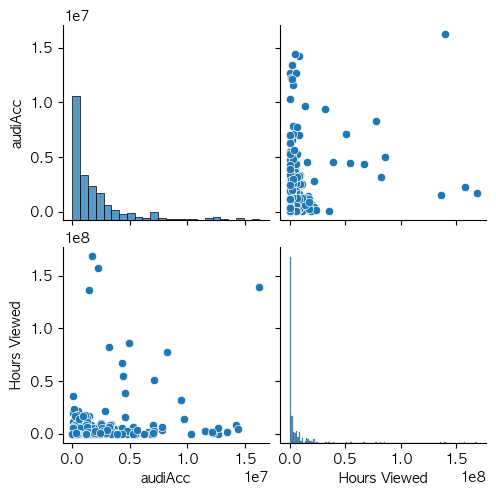

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임 df에서 'audiAcc'와 'Hours Viewed' 간의 pairplot 그리기
sns.pairplot(same_movie[['audiAcc', 'Hours Viewed']])
plt.show()

In [65]:
correlation = same_movie['audiAcc'].corr(same_movie['Hours Viewed'])

print("상관 계수:", correlation)

상관 계수: 0.21164783806087717


=> 넷플릭스 인기 한국 영화랑 박스오피스 인기 한국 영화랑 차이가 상관성이 작다.

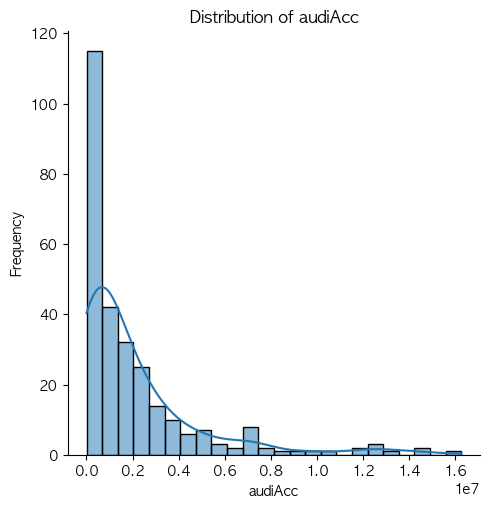

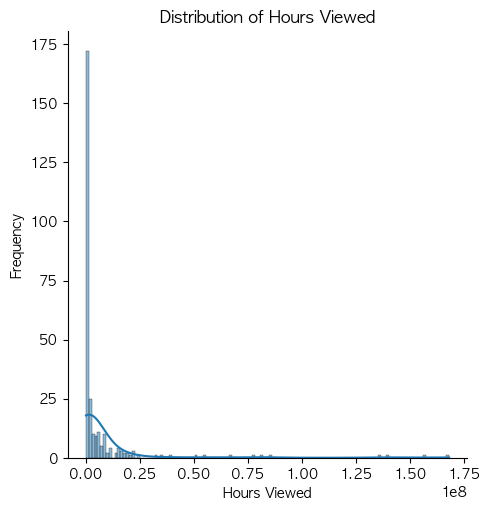

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'audiAcc'에 대한 분포 확인
sns.displot(same_movie['audiAcc'], kde=True)
plt.title('Distribution of audiAcc')
plt.xlabel('audiAcc')
plt.ylabel('Frequency')
plt.show()

# 'Hours Viewed'에 대한 분포 확인
sns.displot(same_movie['Hours Viewed'], kde=True)
plt.title('Distribution of Hours Viewed')
plt.xlabel('Hours Viewed')
plt.ylabel('Frequency')
plt.show()


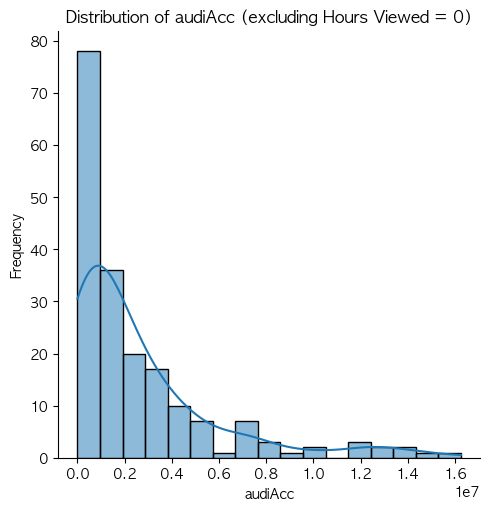

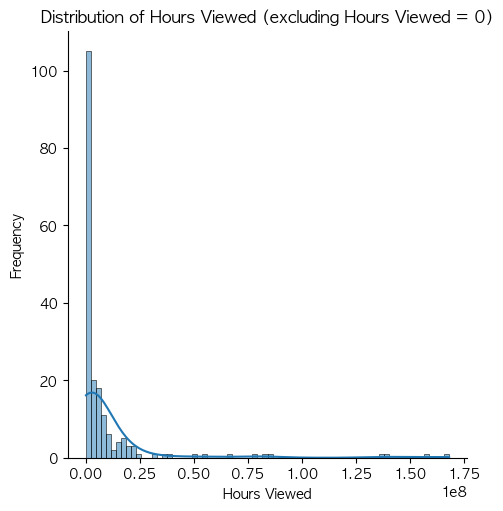

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'Hours Viewed'가 0인 데이터를 제외한 데이터프레임 생성
filtered_df = same_movie[same_movie['Hours Viewed'] != 0]

# 'audiAcc'에 대한 분포 확인
sns.displot(filtered_df['audiAcc'], kde=True)
plt.title('Distribution of audiAcc (excluding Hours Viewed = 0)')
plt.xlabel('audiAcc')
plt.ylabel('Frequency')
plt.show()

# 'Hours Viewed'에 대한 분포 확인
sns.displot(filtered_df['Hours Viewed'], kde=True)
plt.title('Distribution of Hours Viewed (excluding Hours Viewed = 0)')
plt.xlabel('Hours Viewed')
plt.ylabel('Frequency')
plt.show()

In [120]:
print(common_titles['movieNm'].tolist())

['#살아있다', '7년의 밤', '82년생 김지영', 'B컷', 'PMC: 더 벙커', '가려진 시간', '가장 보통의 연애', '간신', '감쪽같은 그녀', '강남 1970', '강릉', '강철비', '강철비2: 정상회담', '걸캅스', '검객', '검사외전', '게이트', '결백', '경관의 피', '고백', '고산자, 대동여지도', '곡성', '곤지암', '공기살인', '공작', '공조', '공조2: 인터내셔날', '괴물', '괴물', '교섭', '국가부도의 날', '국제수사', '국제시장', '군함도', '굿바이 싱글', '궁합', '귀문', '그것만이 내 세상', '그날의 분위기', '극비수사', '극장판 공룡메카드: 타이니소어의 섬', '극장판 안녕 자두야', '극한직업', '기묘한 가족', '기방도령', '기생충', '기술자들', '기억의 밤', '기적', '꾼', '꿈의 제인', '나를 기억해', '나를 잊지 말아요', '나를 찾아줘', '나쁜 녀석들: 더 무비', '남과 여', '남매의 여름밤', '남산의 부장들', '남한산성', '내부자들', '내안의 그놈', '내일의 기억', '너의 결혼식', '늑대사냥', '다만 악에서 구하소서', '담보', '대무가', '대호', '더 박스', '더 킬러: 죽어도 되는 아이', '더 킹', '더 킹', '덕혜옹주', '데시벨', '도굴', '도어락', '독전', '독전: 익스텐디드 컷', '돈', '동감', '동네사람들', '동네사람들', '럭키', '레슬러', '롱 리브 더 킹: 목포 영웅', '루시드 드림', '리얼', '리틀 포레스트', '마녀', '마루이 비디오', '마스터', '마약왕', '말모이', '명당', '모가디슈', '목격자', '무뢰한', '물괴', '미나리', '미드나이트', '미션 파서블', '미스터 보스', '미스터 주: 사라진 VIP', '미쓰 와이프', '미쓰백', '미씽: 사라진 여자', '미씽: 사라진 여자', '미옥', '미혹', '바람 바람 바람', '반도', '반드

### 3.3. 넷플릭스에서 인기있는 영화 or 영화 극장에서 인기있는 영화

- 전체(겹치는 영화)

In [89]:
# Genre 열을 쉼표로 분리하여 리스트로 변환
same_movie['Genre'] = same_movie['Genre'].str.split(', ')

# Genre 열을 개별 행으로 확장
df_exploded = same_movie.explode('Genre')

In [80]:
df_exploded = df_exploded[df_exploded['Type_New'] == 'Movie']

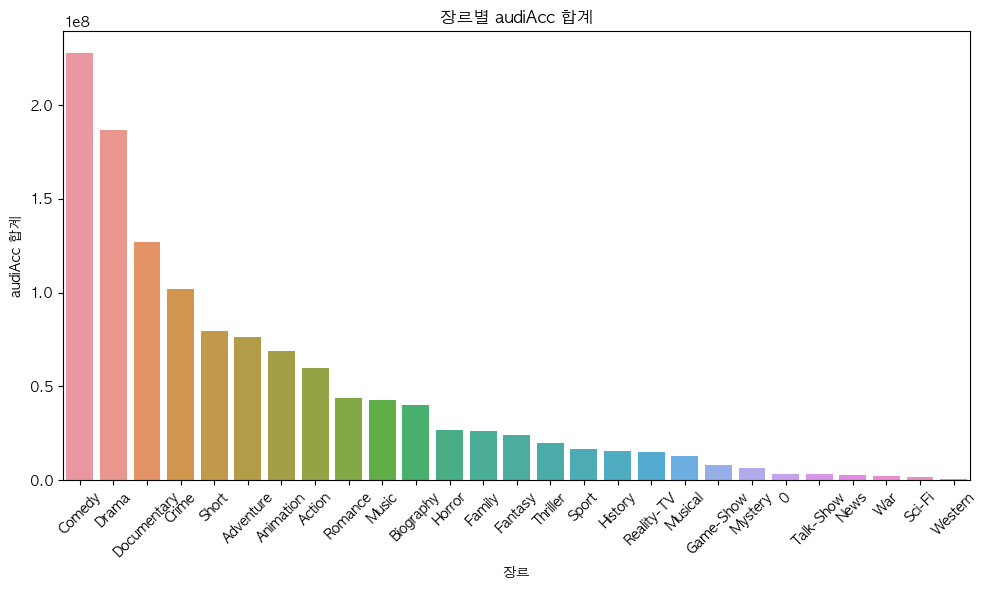

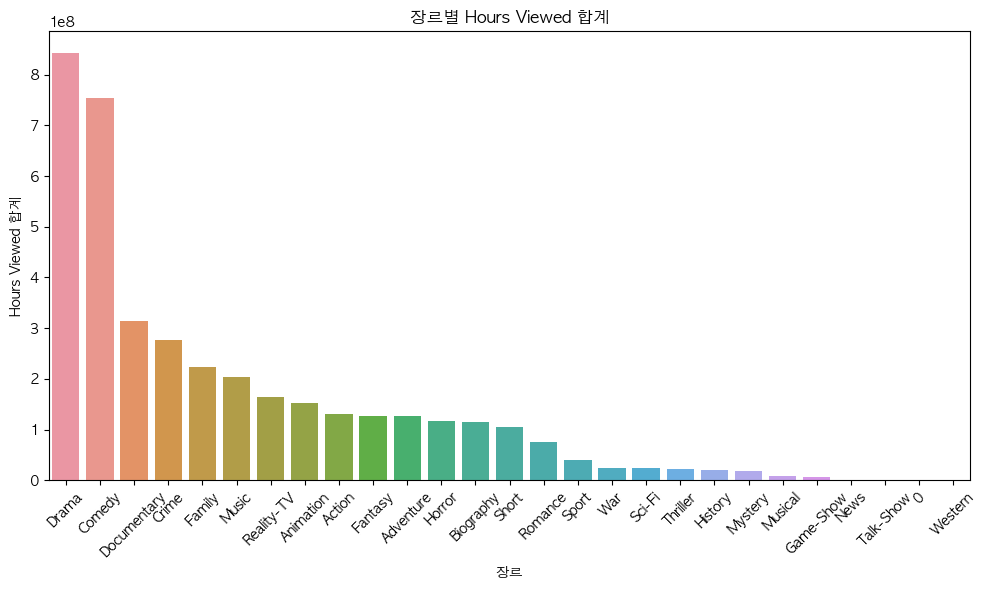

In [94]:
# 장르별로 audiAcc 합산
genre_audiAcc_sum = df_exploded.groupby('Genre')['audiAcc'].sum().reset_index()
# 내림차순으로 정렬
genre_audiAcc_sum = genre_audiAcc_sum.sort_values(by='audiAcc', ascending=False)

# 장르별로 Hours Viewed 합산
genre_hours_sum = df_exploded.groupby('Genre')['Hours Viewed'].sum().reset_index()
# 내림차순으로 정렬
genre_hours_sum = genre_hours_sum.sort_values(by='Hours Viewed', ascending=False)

# 그래프 그리기 - audiAcc 합계
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Genre', y='audiAcc', data=genre_audiAcc_sum, ax=ax)
ax.set_title('장르별 audiAcc 합계')
ax.set_xlabel('장르')
ax.set_ylabel('audiAcc 합계')
ax.tick_params(axis='x', rotation=45)  # label rotation 설정
plt.tight_layout()
plt.show()

# 그래프 그리기 - Hours Viewed 합계
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Genre', y='Hours Viewed', data=genre_hours_sum, ax=ax)
ax.set_title('장르별 Hours Viewed 합계')
ax.set_xlabel('장르')
ax.set_ylabel('Hours Viewed 합계')
ax.tick_params(axis='x', rotation=45)  # label rotation 설정
plt.tight_layout()
plt.show()

=> 겹치는 영화 간에 넷플릭스와 장르별 큰 차이는 없다.

In [96]:
# Genre 열을 쉼표로 분리하여 리스트로 변환
df_korea_movie['Genre'] = df_korea_movie['Genre'].str.split(', ')

# Genre 열을 개별 행으로 확장
df_exploded = df_korea_movie.explode('Genre')

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_genre_statistics(df_exploded):
    # 장르별로 audiAcc 합산
    # genre_audiAcc_sum = df_exploded.groupby('Genre')['audiAcc'].sum().reset_index()
    # # 내림차순으로 정렬
    # genre_audiAcc_sum = genre_audiAcc_sum.sort_values(by='audiAcc', ascending=False)

    # 장르별로 Hours Viewed 합산
    genre_hours_sum = df_exploded.groupby('Genre')['Hours Viewed'].sum().reset_index()
    # 내림차순으로 정렬
    genre_hours_sum = genre_hours_sum.sort_values(by='Hours Viewed', ascending=False)

    # # 그래프 그리기 - audiAcc 합계
    # fig, ax = plt.subplots(figsize=(10, 6))
    # sns.barplot(x='Genre', y='audiAcc', data=genre_audiAcc_sum, ax=ax)
    # ax.set_title('장르별 audiAcc 합계')
    # ax.set_xlabel('장르')
    # ax.set_ylabel('audiAcc 합계')
    # ax.tick_params(axis='x', rotation=45)  # label rotation 설정
    # plt.tight_layout()
    # plt.show()

    # 그래프 그리기 - Hours Viewed 합계
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Genre', y='Hours Viewed', data=genre_hours_sum, ax=ax)
    ax.set_title('장르별 Hours Viewed 합계')
    ax.set_xlabel('장르')
    ax.set_ylabel('Hours Viewed 합계')
    ax.tick_params(axis='x', rotation=45)  # label rotation 설정
    plt.tight_layout()
    plt.show()

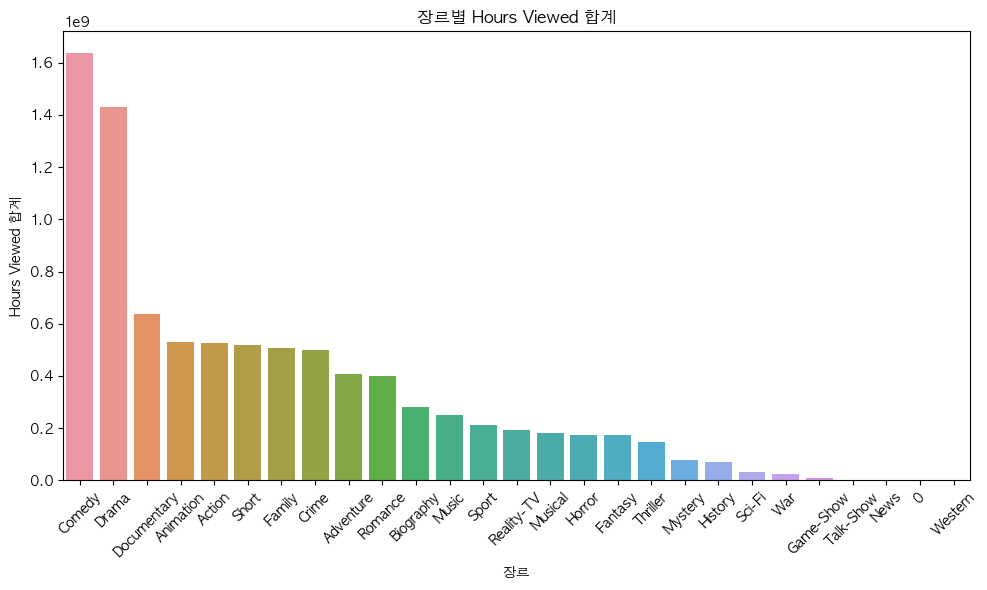

In [101]:
plot_genre_statistics(df_exploded)

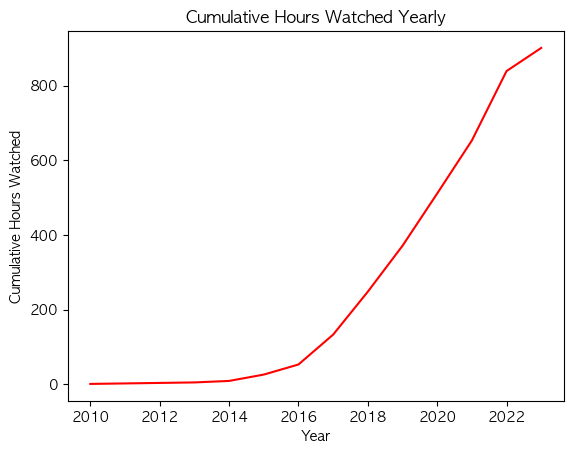

In [113]:
df_clean = df_korea.dropna(subset=['release_date_parsed']) # Nat 제거

# year 추출
df_clean['release_year'] = df_clean['release_date_parsed'].dt.year

# Group by
yearly_hours = df_clean.groupby('release_year')['Hours Viewed'].count()

# Calculate
cumulative_hours = yearly_hours.cumsum()

# Plotting
cumulative_hours.plot(kind='line', title='Cumulative Hours Watched Yearly', color='red')
plt.xlabel('Year')
plt.ylabel('Cumulative Hours Watched')
plt.show()

In [116]:
cumulative_hours

release_year
2010      1
2013      5
2014      9
2015     26
2016     53
2017    133
2018    248
2019    371
2020    511
2021    653
2022    839
2023    901
Name: Hours Viewed, dtype: int64

In [117]:
counts_yearly_korea= cumulative_hours.reset_index()
counts_yearly_korea.columns = ['release_year', 'Counts']

In [118]:
counts_yearly_korea

,release_year,Counts
0,2010,1
1,2013,5
2,2014,9
3,2015,26
4,2016,53
5,2017,133
6,2018,248
7,2019,371
8,2020,511
9,2021,653
